<a href="https://colab.research.google.com/github/yousrabougara/WalmartSalesForecasting/blob/main/XGBoost_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install category_encoders

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.preprocessing import StandardScaler ,PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression , Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from xgboost import XGBRegressor
from category_encoders import BinaryEncoder
import pickle
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df=pd.read_csv('Walmart.csv')

In [17]:
df.head(5)

,Store_0,Store_1,Store_2,Store_3,Store_4,Store_5,Date,Weekly_Sales,Holiday_Flag,Temperature,...,Unemployment,Month,Year,Season_0,Season_1,Season_2,Lag_1,Lag_2,Lag_3,Lag_4
0,0,0,0,0,0,1,2010-02-05,1.057420,0,-0.995136,...,0.056964,2,2010,0,0,1,-1.826402,-1.798349,-1.771203,-1.744944
1,0,0,0,0,0,1,2010-02-12,1.054348,1,-1.201170,...,0.056964,2,2010,0,0,1,1.060488,-1.798349,-1.771203,-1.744944
2,0,0,0,0,0,1,2010-02-19,1.001206,0,-1.124178,...,0.056964,2,2010,0,0,1,1.057444,1.063497,-1.771203,-1.744944
3,0,0,0,0,0,1,2010-02-26,0.642828,0,-0.760907,...,0.056964,2,2010,0,0,1,1.004772,1.060478,1.067142,-1.744944
4,0,0,0,0,0,1,2010-03-05,0.899914,0,-0.767955,...,0.056964,3,2010,0,1,0,0.649568,1.008264,1.064149,1.071619


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [ ]:
df.isna().sum()

,0
Store,0
Date,0
Weekly_Sales,0
Holiday_Flag,0
Temperature,0
Fuel_Price,0
CPI,0
Unemployment,0


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [ ]:
def get_season(month):
    '''this function is to get season according to month column'''
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [ ]:
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Season'] = df['Month'].apply(get_season)

In [ ]:
# Ajouter des colonnes de lag
df['Lag_1'] = df.groupby('Store')['Weekly_Sales'].shift(1)  # Lag d'une semaine
df['Lag_2'] = df.groupby('Store')['Weekly_Sales'].shift(2)  # Lag de deux semaines
df['Lag_3'] = df.groupby('Store')['Weekly_Sales'].shift(3)  # Lag de trois semaines



In [ ]:
df['Lag_4'] = df.groupby('Store')['Weekly_Sales'].shift(4)  # Lag de trois semaines

In [ ]:
df.fillna(0, inplace=True)

In [ ]:
df.head(6)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month,Year,Season,Lag_1,Lag_2,Lag_3,Lag_4
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2,2010,Winter,0.00,0.00,0.00,0.00
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2,2010,Winter,1643690.90,0.00,0.00,0.00
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2,2010,Winter,1641957.44,1643690.90,0.00,0.00
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2,2010,Winter,1611968.17,1641957.44,1643690.90,0.00
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,3,2010,Spring,1409727.59,1611968.17,1641957.44,1643690.90
5,1,2010-03-12,1439541.59,0,57.79,2.667,211.380643,8.106,3,2010,Spring,1554806.68,1409727.59,1611968.17,1641957.44


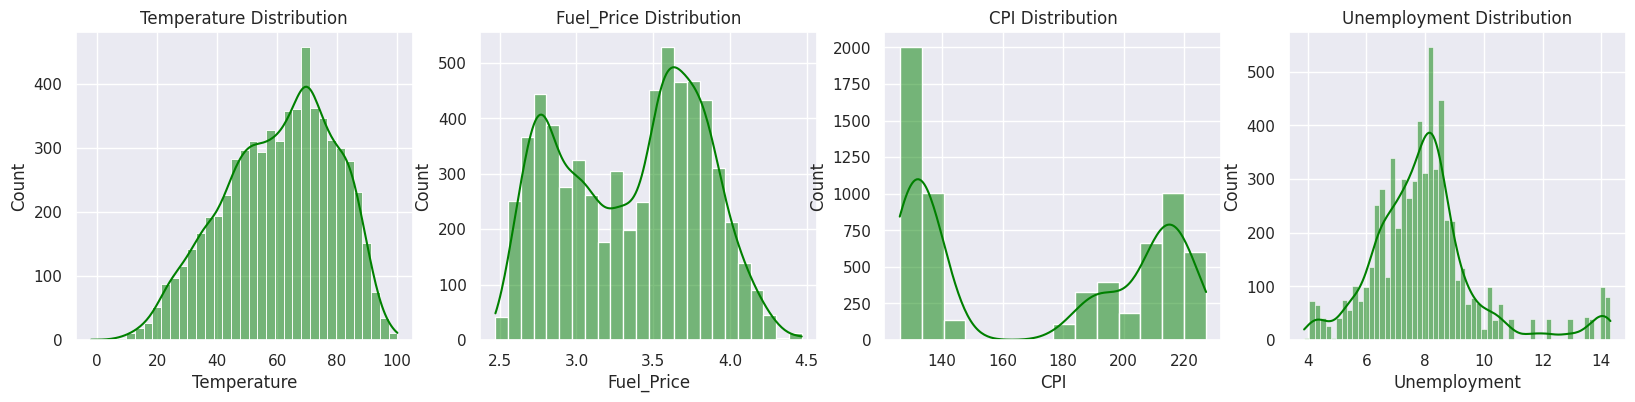

In [ ]:
fig , ax = plt.subplots(1,4,figsize=(20,4))
cols = ['Temperature','Fuel_Price','CPI','Unemployment']
for i,col in enumerate(cols):
    sns.histplot(df,
                 x=col,
                 ax=ax[i],
                 kde=True,
                 color = 'green'
                )
    ax[i].set_title(f'{col} Distribution')
fig.show()

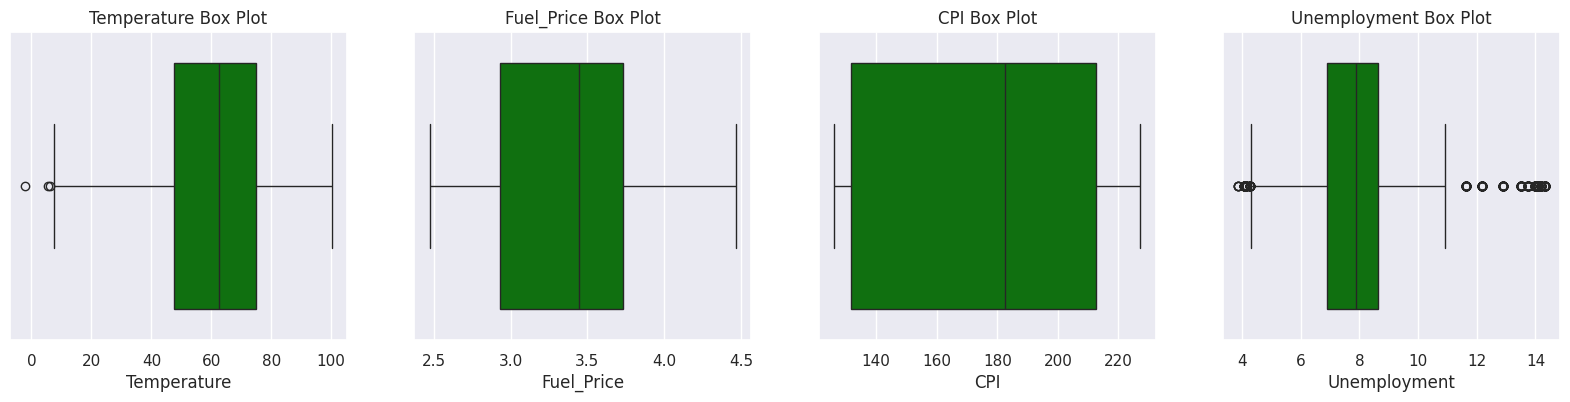

In [ ]:
fig , ax = plt.subplots(1,4,figsize=(20,4))
cols = ['Temperature','Fuel_Price','CPI','Unemployment']
for i,col in enumerate(cols):
    sns.boxplot(df,
                 x=col,
                 ax=ax[i],
                 color = 'green'
                )
    ax[i].set_title(f'{col} Box Plot')
fig.show()

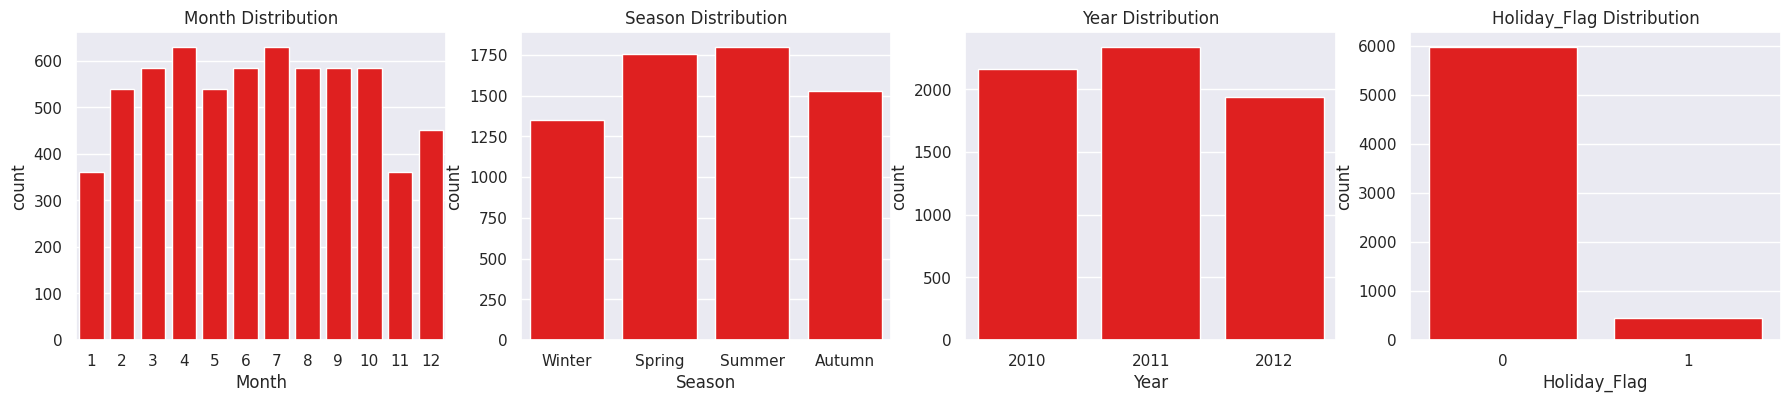

In [ ]:
fig , ax = plt.subplots(1,4,figsize=(22,4))
cols = ['Month','Season','Year','Holiday_Flag']
for i,col in enumerate(cols):
    sns.countplot(df,
                 x=col,
                 ax=ax[i],
                 color = 'Red'
                )
    ax[i].set_title(f'{col} Distribution')
fig.show()

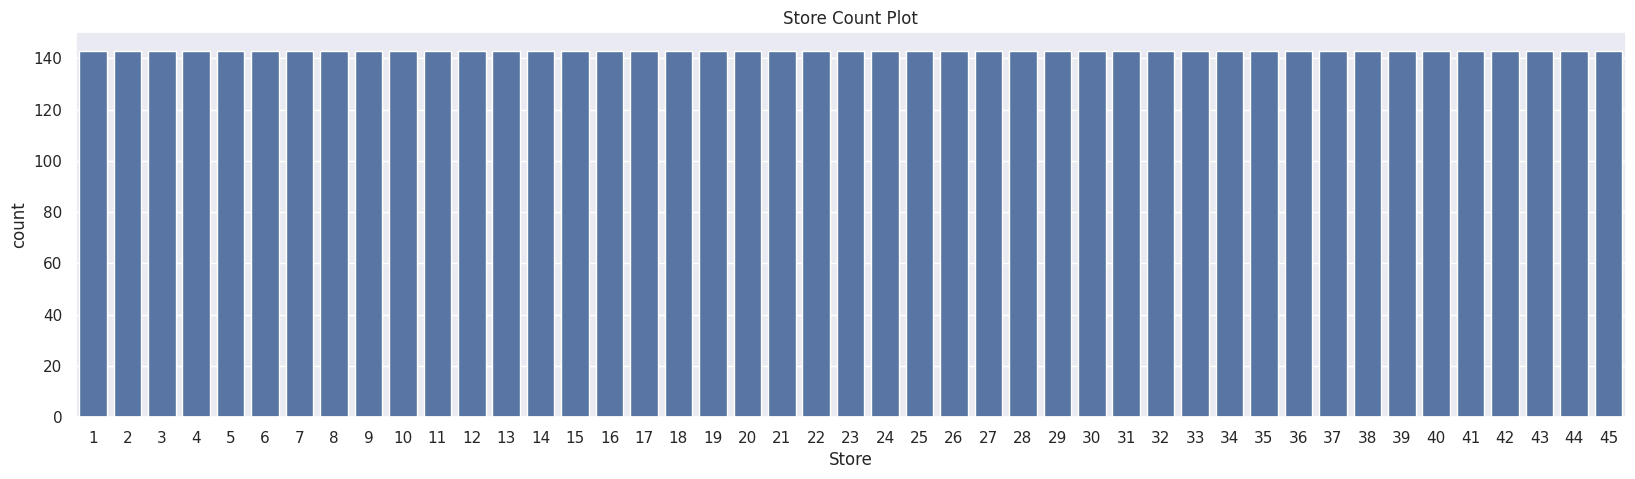

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot(df,x='Store');
plt.title('Store Count Plot');

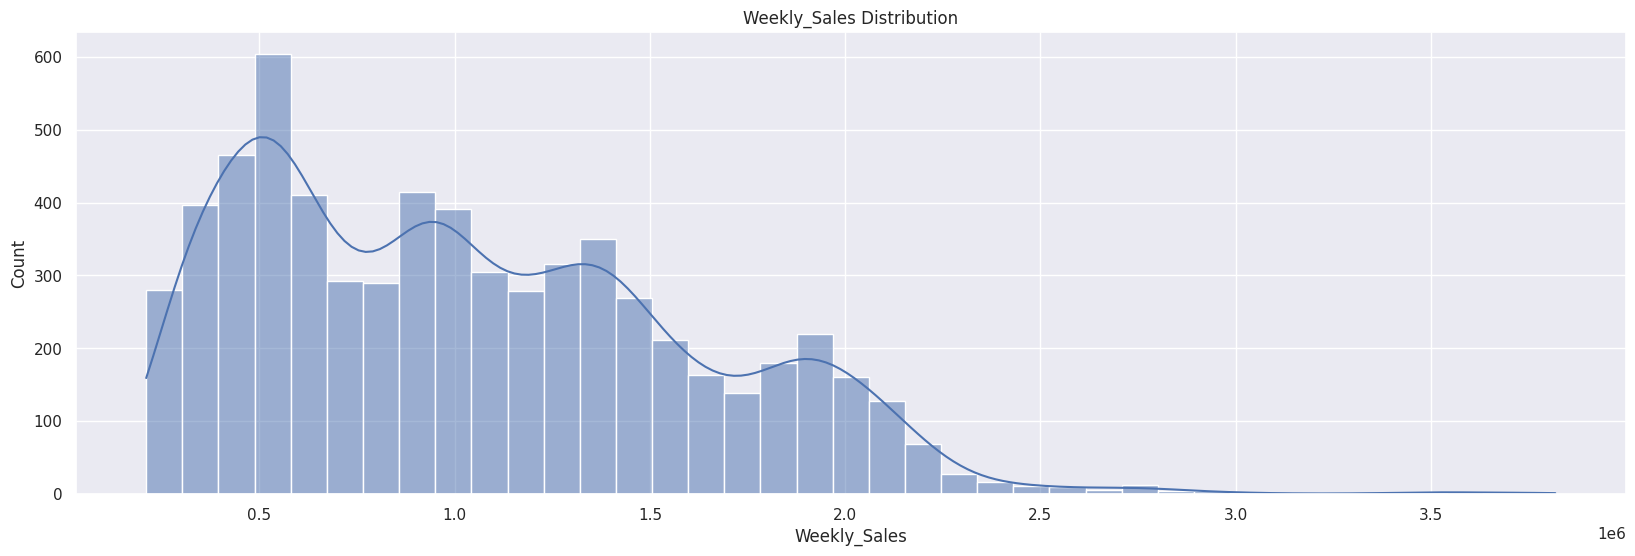

In [ ]:
plt.figure(figsize=(20,6))
sns.histplot(x=df['Weekly_Sales'],kde=True);
plt.title('Weekly_Sales Distribution');

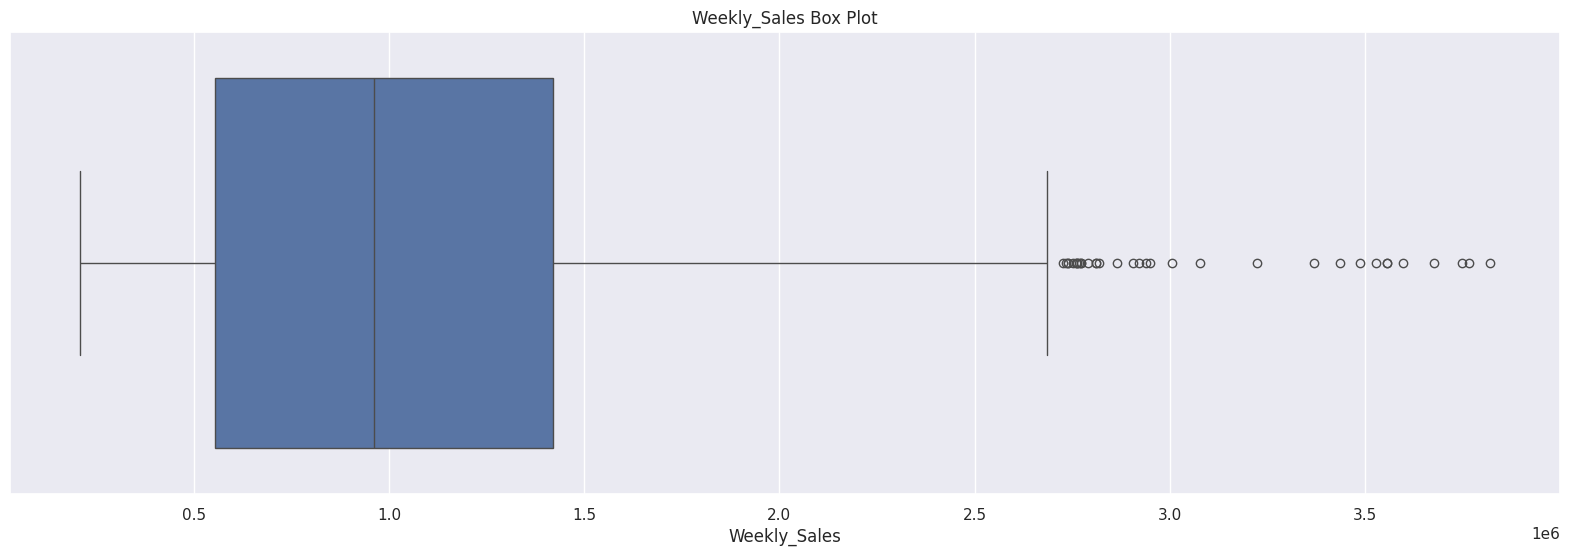

In [ ]:
plt.figure(figsize=(20,6))
sns.boxplot(x=df['Weekly_Sales']);
plt.title('Weekly_Sales Box Plot');


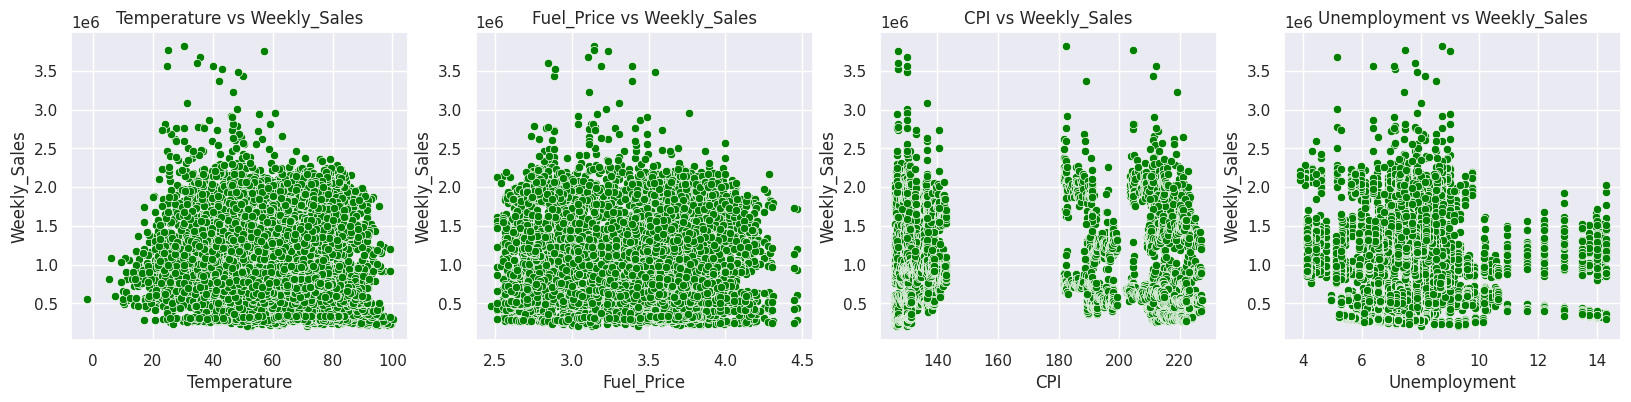

In [ ]:
fig , ax = plt.subplots(1,4,figsize=(20,4))
cols = ['Temperature','Fuel_Price','CPI','Unemployment']
for i,col in enumerate(cols):
    sns.scatterplot(df,
                 y='Weekly_Sales',x=col,
                 ax=ax[i],
                 color = 'green'
                )
    ax[i].set_title(f'{col} vs Weekly_Sales')
fig.show()

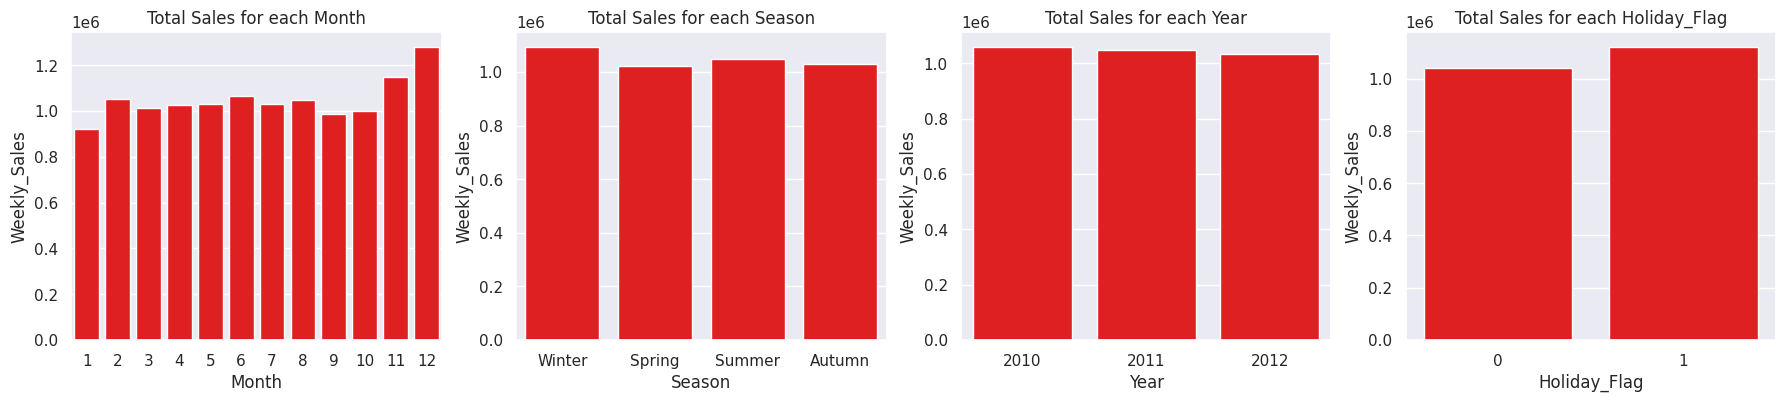

In [ ]:
fig , ax = plt.subplots(1,4,figsize=(22,4))
cols = ['Month','Season','Year','Holiday_Flag']
for i,col in enumerate(cols):
    sns.barplot(df,
                 x=col,y='Weekly_Sales',
                 ax=ax[i],
                 errorbar=None,
                 color='Red'
                )
    ax[i].set_title(f'Total Sales for each {col}')
fig.show()

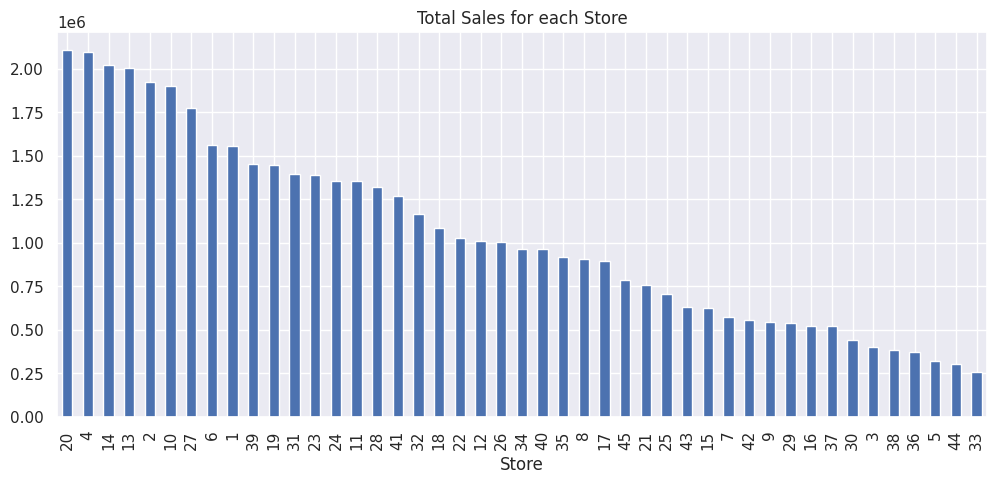

In [ ]:
plt.figure(figsize=(12,5))
df.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False).plot(kind='bar');
plt.title('Total Sales for each Store');

In [ ]:
df['Store'] = df['Store'].astype('object')

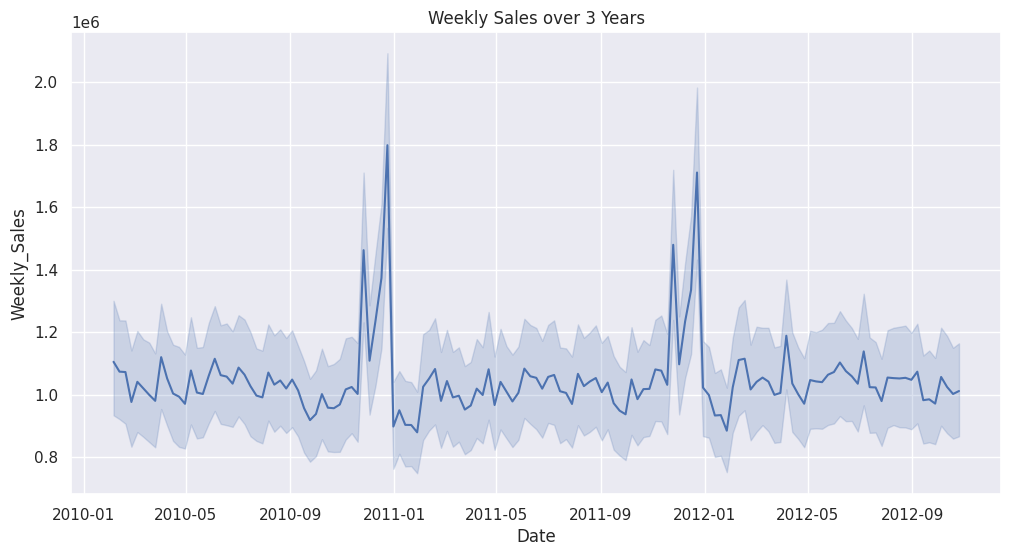

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df["Date"],y=df['Weekly_Sales']);
plt.title('Weekly Sales over 3 Years');

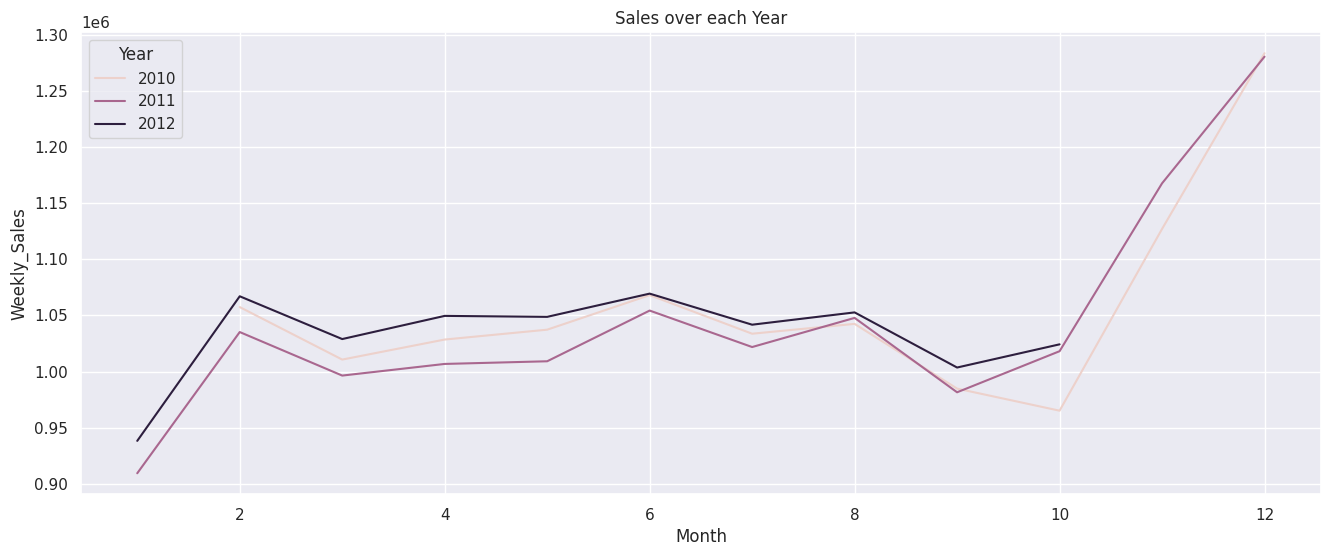

In [ ]:
plt.figure(figsize=(16,6))
sns.lineplot(x=df["Month"],y=df['Weekly_Sales'],hue=df['Year'],ci=None);
plt.title('Sales over each Year');

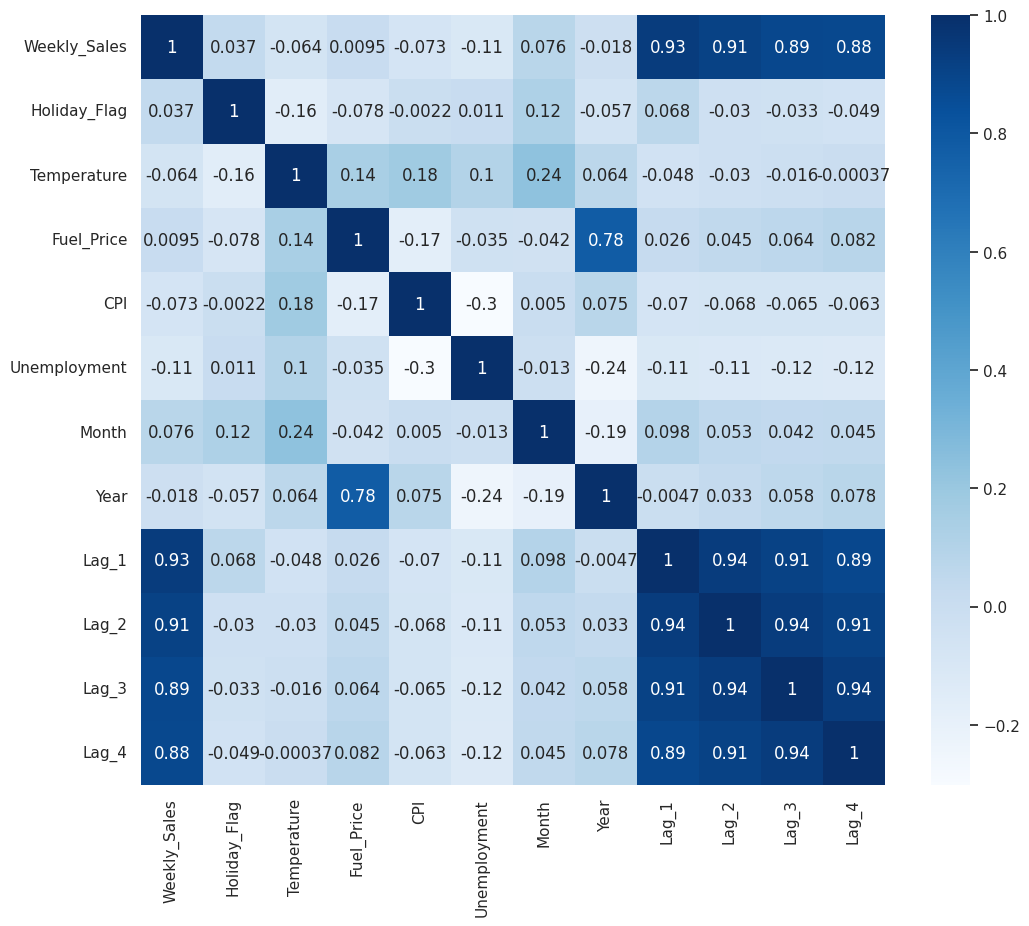

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True),cmap='Blues',annot=True);

In [ ]:
num_vars = ['Temperature','Fuel_Price','CPI','Unemployment','Weekly_Sales','Lag_1','Lag_2','Lag_3','Lag_4']

# scaling numerical variables
sc = StandardScaler()
df[num_vars] = sc.fit_transform(df[num_vars])

# encoding categorical features
encoder = BinaryEncoder(cols=['Store','Season'])
df = encoder.fit_transform(df)

In [ ]:
features = df.columns.drop(['Weekly_Sales','Date','Year'])
target = 'Weekly_Sales'

X = df[features]
y = df[target]

X_train , X_test , y_train , y_test = train_test_split(X,y,random_state=42 ,  test_size=0.2)

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.5 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "subsample": trial.suggest_float("subsample", 0.9, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.9, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 0, 7),
        "gamma": trial.suggest_float("gamma", 0.001, 0.3),
    }

    # Créer le modèle avec les paramètres proposés
    model = XGBRegressor(**params, n_jobs=-1)

    # Entraîner le modèle
    model.fit(X_train, y_train)

    # Prédictions sur le jeu de test
    y_pred = model.predict(X_test)

    # Calculer le score R² (le score à maximiser)
    r2 = r2_score(y_test, y_pred)

    return r2


In [ ]:
# Créer une étude Optuna pour maximiser le score R²
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)  # Essayer 50 combinaisons de paramètres
results = []
for trial in study.trials:
    trial_result = trial.params.copy()
    trial_result['r2_score'] = trial.value
    trial_result['trial_number'] = trial.number
    results.append(trial_result)

# 📌 Convertir en DataFrame
results_df = pd.DataFrame(results)

# Afficher les meilleurs paramètres trouvés par Optuna
best_params = study.best_params
print("Best parameters found by Optuna:", best_params)

# Construire le modèle avec les meilleurs paramètres trouvés
xgb_best = XGBRegressor(**best_params, n_jobs=-1)

# Entraîner le modèle final sur le jeu d'entraînement
xgb_best.fit(X_train, y_train)

# Évaluation sur le jeu de test
y_pred = xgb_best.predict(X_test)

# Calculer le score R² sur le jeu de test
r2 = r2_score(y_test, y_pred)
print("Final Test R2 Score:", r2)

# Afficher les précisions
print("Training set Accuracy:", round(xgb_best.score(X_train, y_train), 3) * 100)
print("Test set Accuracy:", round(xgb_best.score(X_test, y_test), 3) * 100)


[I 2024-12-26 11:03:10,455] A new study created in memory with name: no-name-b1b16b74-cfe0-4820-a073-930388e950a5
[I 2024-12-26 11:03:11,634] Trial 0 finished with value: 0.8858077305001791 and parameters: {'n_estimators': 816, 'learning_rate': 0.0017067031609027694, 'max_depth': 4, 'subsample': 0.9541136769581914, 'colsample_bytree': 0.928036265287182, 'min_child_weight': 4, 'gamma': 0.1228732066206102}. Best is trial 0 with value: 0.8858077305001791.
[I 2024-12-26 11:03:13,925] Trial 1 finished with value: 0.9646677329119866 and parameters: {'n_estimators': 567, 'learning_rate': 0.004179124762736173, 'max_depth': 7, 'subsample': 0.9692164390369308, 'colsample_bytree': 0.9311457296658738, 'min_child_weight': 5, 'gamma': 0.14129433671837854}. Best is trial 1 with value: 0.9646677329119866.
[I 2024-12-26 11:03:14,354] Trial 2 finished with value: 0.9683045650049042 and parameters: {'n_estimators': 813, 'learning_rate': 0.05711515964731847, 'max_depth': 3, 'subsample': 0.9658211165128013

Best parameters found by Optuna: {'n_estimators': 389, 'learning_rate': 0.06764841104371175, 'max_depth': 7, 'subsample': 0.9881854546334644, 'colsample_bytree': 0.9881200971577537, 'min_child_weight': 3, 'gamma': 0.0019897610157878737}
Final Test R2 Score: 0.9800080085476877
Training set Accuracy: 99.7
Test set Accuracy: 98.0


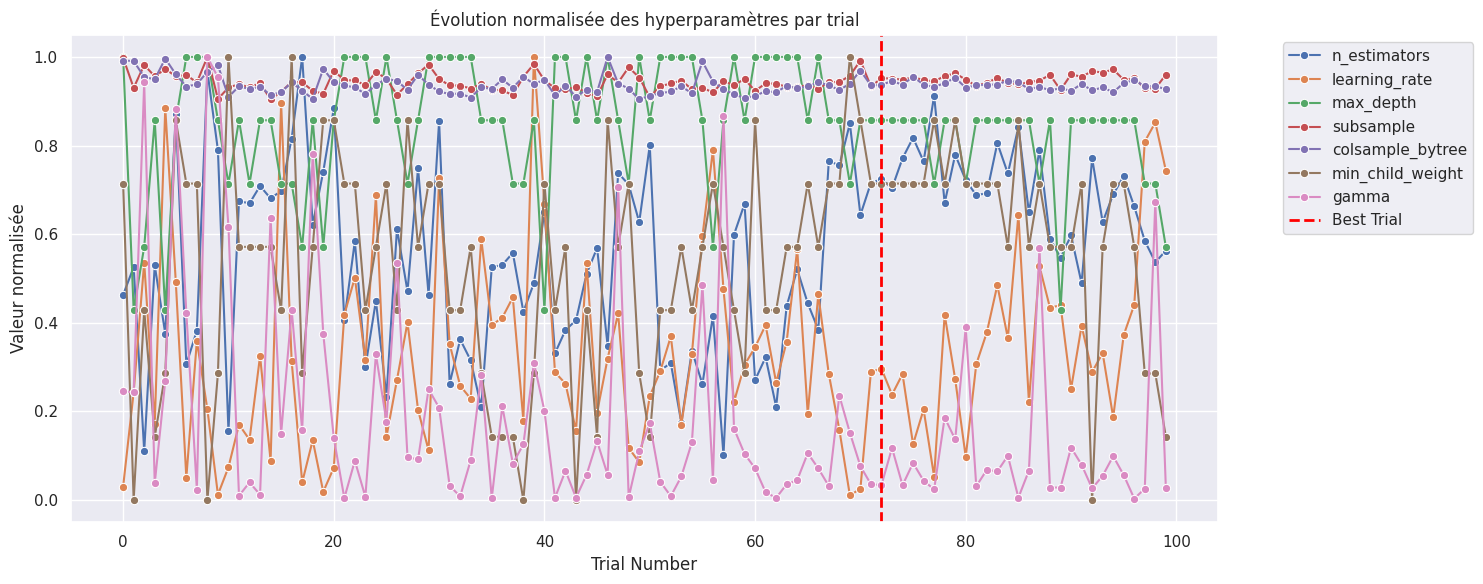

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Liste des colonnes à tracer (sauf score et numéro de trial)
params_to_plot = [col for col in results_df.columns if col not in ["r2_score", "trial_number"]]

# 📌 Création d'une copie pour normalisation
normalized_df = results_df.copy()

# 📌 Normalisation des paramètres : ramène chaque paramètre entre 0 et 1
for col in params_to_plot:
    max_val = normalized_df[col].max()
    if max_val != 0:
        normalized_df[col] = normalized_df[col] / max_val

# 📌 Réorganisation des données au format long
long_df = normalized_df.melt(
    id_vars=["trial_number"],
    value_vars=params_to_plot,
    var_name="hyperparameter",
    value_name="value"
)

# 📌 Récupération du numéro du best trial
best_trial_number = study.best_trial.number

# 📌 Tracer tous les hyperparamètres dans un seul graphique
plt.figure(figsize=(15, 6))
sns.lineplot(data=long_df, x="trial_number", y="value", hue="hyperparameter", marker="o")

# 📌 Marquer le best trial avec une ligne verticale
plt.axvline(x=best_trial_number, color='red', linestyle='--', linewidth=2, label='Best Trial')

plt.title("Évolution normalisée des hyperparamètres par trial")
plt.xlabel("Trial Number")
plt.ylabel("Valeur normalisée")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Créer une étude Optuna pour maximiser le score R²
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)  # Essayer 50 combinaisons de paramètres

# Afficher les meilleurs paramètres trouvés par Optuna
best_params = study.best_params
print("Best parameters found by Optuna:", best_params)

# Construire le modèle avec les meilleurs paramètres trouvés
xgb_best = XGBRegressor(**best_params, n_jobs=-1)

# Entraîner le modèle final sur le jeu d'entraînement
xgb_best.fit(X_train, y_train)

# Évaluation sur le jeu de test
y_pred = xgb_best.predict(X_test)

# Calculer le score R² sur le jeu de test
r2 = r2_score(y_test, y_pred)
print("Final Test R2 Score:", r2)

# Afficher les précisions
print("Training set Accuracy:", round(xgb_best.score(X_train, y_train), 3) * 100)
print("Test set Accuracy:", round(xgb_best.score(X_test, y_test), 3) * 100)


[I 2024-12-26 11:05:06,330] A new study created in memory with name: no-name-ca1edbc9-c79d-4156-829d-988547743cbe
[I 2024-12-26 11:05:06,746] Trial 0 finished with value: 0.9718227060122796 and parameters: {'n_estimators': 779, 'learning_rate': 0.060880353412867225, 'max_depth': 4, 'subsample': 0.947272625271261, 'colsample_bytree': 0.9970897397023423, 'min_child_weight': 1, 'gamma': 0.24393408122795476}. Best is trial 0 with value: 0.9718227060122796.
[I 2024-12-26 11:05:09,256] Trial 1 finished with value: 0.9480362970595956 and parameters: {'n_estimators': 827, 'learning_rate': 0.002334004034195777, 'max_depth': 6, 'subsample': 0.9554679565468076, 'colsample_bytree': 0.9460708333743899, 'min_child_weight': 5, 'gamma': 0.1881492281764034}. Best is trial 0 with value: 0.9718227060122796.
[I 2024-12-26 11:05:09,987] Trial 2 finished with value: 0.9756906962498729 and parameters: {'n_estimators': 718, 'learning_rate': 0.02374190773872947, 'max_depth': 6, 'subsample': 0.9517908592364746,

Best parameters found by Optuna: {'n_estimators': 771, 'learning_rate': 0.031237892142267274, 'max_depth': 7, 'subsample': 0.9545270641186046, 'colsample_bytree': 0.9501011237254463, 'min_child_weight': 2, 'gamma': 0.001060118868010591}
Final Test R2 Score: 0.9806695783773672
Training set Accuracy: 99.9
Test set Accuracy: 98.1


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Display metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Mean Squared Error (MSE): 0.0196
Mean Absolute Error (MAE): 0.0888
Root Mean Squared Error (RMSE): 0.1398
R-squared (R²): 0.9807


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Best parameters found by Optuna
best_params = {
    'n_estimators': 653,
    'learning_rate': 0.04980968952465322,
    'max_depth': 5,
    'subsample': 0.8687316370065182,
    'colsample_bytree': 0.9812409373488375,
    'min_child_weight': 2,
    'gamma': 0.0013757013130098134
}

# Create the model with the best parameters
xgb_best = XGBRegressor(**best_params, n_jobs=-1)

# Train the model on the training set
xgb_best.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = xgb_best.predict(X_test)

# Calculate R² score on the test set
r2 = r2_score(y_test, y_pred)
print("Final Test R² Score:", r2)

# Display accuracies
print("Training set Accuracy:", round(xgb_best.score(X_train, y_train), 3) * 100)
print("Test set Accuracy:", round(xgb_best.score(X_test, y_test), 3) * 100)


Final Test R² Score: 0.9806969874934286
Training set Accuracy: 99.6
Test set Accuracy: 98.1
